### Estimate persistence parameters and seasonal cycle from Norkyst800 data at station(s)

In [1]:
%load_ext autoreload
%autoreload 2

from pyclarify import ClarifyClient, query, SignalInfo, DataFrame
import matplotlib.pyplot as plt
from forecast_clarify.main import *
import xarray as xr
from datetime import timedelta
import os

In [2]:
client = ClarifyClient('../data/credentials/credentials_ow_persistence.json')

item_id = ["ca8dhakpllnee2k58qfg"]
filter = query.Filter(fields={"id": query.In(value=item_id)})

response_filtered = client.select_items(
    filter = filter,
    include_metadata = True,
    include_dataframe = True,
    not_before = "2019-05-01T00:00:00Z",
    before = datetime.today(),
    rollup = "P7DT"
)
# question: is the time tag that comes out of the rollup the center of the window?

st3m_langoey = response_filtered.result.data.to_pandas()
print(st3m_langoey.index[-10:])

DatetimeIndex(['2022-07-11 00:00:00+00:00', '2022-07-18 00:00:00+00:00',
               '2022-07-25 00:00:00+00:00', '2022-08-01 00:00:00+00:00',
               '2022-08-08 00:00:00+00:00', '2022-08-15 00:00:00+00:00',
               '2022-08-22 00:00:00+00:00', '2022-08-29 00:00:00+00:00',
               '2022-09-26 00:00:00+00:00', '2022-10-03 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)


In [3]:
# center time axis on middle of the averaging window (current index is the beginning of the 7-day (168 hrs) window):
st3m_langoey.index = st3m_langoey.index + timedelta(hours=84)

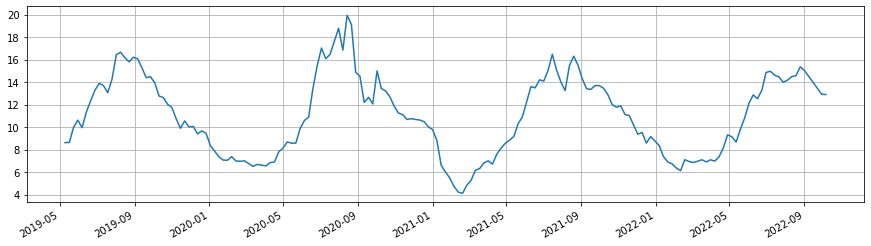

In [4]:
f,ax = plt.subplots(figsize=(15,4))
st3m_langoey.ca8dhakpllnee2k58qfg_avg.plot(ax=ax)
# st3m_langoey.ca8dhakpllnee2k58qfg_min.plot(ax=ax)
# st3m_langoey.ca8dhakpllnee2k58qfg_max.plot(ax=ax)
ax.grid()

Get Norkyst800 at the same station(s):

In [18]:
pth = '/projects/NS9853K/DATA/norkyst800/station_3m/'
file = os.path.join(pth,'temperature_insitu_3m_norkyst800_barentswatch_closest_20120627-20220919.nc')

ds = xr.open_dataset(file).sortby('time')

In [19]:
langoey_all = [(dsl,dsn,dslat,dslon) for dsn,dsl,dslat,dslon in zip(ds.loc_name.values,ds.location.values,ds.lat.values,ds.lon.values) if 'Langøy' in dsn]
langoey_id = [la[0] for la in langoey_all]

In [20]:
d = st3m_langoey.ca8dhakpllnee2k58qfg_avg.index
date_set = set(pd.Timestamp(d[0]) + timedelta(days = int(x*7)) for x in range(int((d[-1] - d[0]).days/7)))
missing = sorted(date_set - set(d))
missing

[Timestamp('2021-11-25 12:00:00+0000', tz='UTC'),
 Timestamp('2022-09-08 12:00:00+0000', tz='UTC'),
 Timestamp('2022-09-15 12:00:00+0000', tz='UTC'),
 Timestamp('2022-09-22 12:00:00+0000', tz='UTC')]

In [21]:
ds_weekly = ds.sel(time=slice(st3m_langoey.ca8dhakpllnee2k58qfg_avg.index[0],st3m_langoey.ca8dhakpllnee2k58qfg_avg.index[-1] + timedelta(hours=12))).resample(time='7D').mean() # will have nans!

/projects/NS9001K/owul/conda/envs/forecast_clarify/lib/python3.10/site-packages/xarray/core/indexes.py:97: FutureWarning: Indexing a timezone-naive DatetimeIndex with a timezone-aware datetime is deprecated and will raise KeyError in a future version.  Use a timezone-naive object instead.
  indexer = index.slice_indexer(


In [22]:
np.argmin(abs(ds.lat.values  - 59.99)),np.argmin(abs(ds.lon.values  - 5.93))

(337, 337)

In [23]:
ds_weekly.time.isel(time=133)

<xarray.DataArray 'time' ()>
array('2021-11-25T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2021-11-25

In [24]:
np.corrcoef(np.delete(ds_weekly.sel(location=langoey_id[0]).temperature.values,133),st3m_langoey.ca8dhakpllnee2k58qfg_avg.values)[0,1]

0.9372895612685833

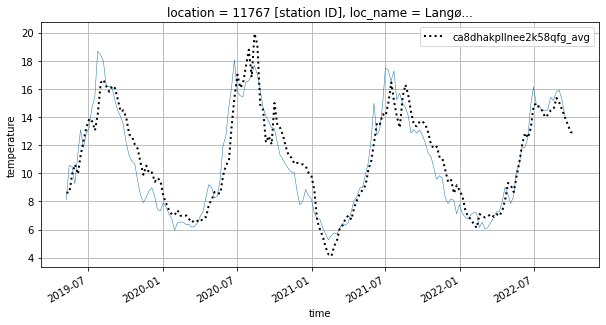

In [25]:
f,ax = plt.subplots(figsize=(10,5))
ds_weekly.sel(location=langoey_id[1]).temperature.plot(hue='location',label='',ax=ax,linewidth=.5);
st3m_langoey.ca8dhakpllnee2k58qfg_avg.plot(ax=ax,color='k',linewidth=2,linestyle='dotted')
# ax.set_xlim([st3m_langoey.ca8dhakpllnee2k58qfg_avg.index[0],st3m_langoey.ca8dhakpllnee2k58qfg_avg.index[-1]])
ax.grid()
plt.legend()

Choose Langøy S as the station

In [26]:
ds.squeeze().isel(location=337).location

<xarray.DataArray 'location' ()>
array(22095)
Coordinates:
    depth     int64 3
    location  int64 22095
    loc_name  object 'Hågardsneset'
    lon       float64 5.93
    lat       float64 59.98
Attributes:
    units:    station ID

In [27]:
temp_3m_langoey = ds.squeeze().isel(location=337).rolling(time=7,min_periods=7,center=True).mean('time').isel(time=slice(3,-3)).sortby('time')

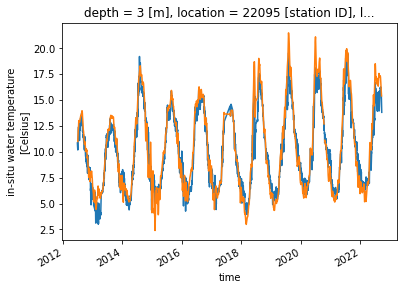

In [28]:
ds.squeeze().sel(location=langoey_id[0]).temperature.plot()
temp_3m_langoey.temperature.plot()

Remove trend?

In [29]:
trnd = trend(degree=1)
trnd.fit(temp_3m_langoey)
data_dtr = trnd.detrend()

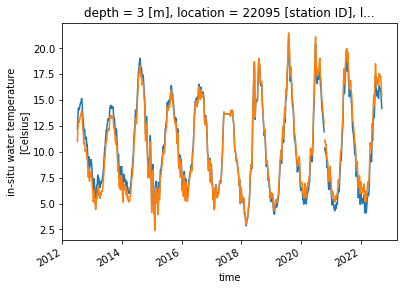

In [30]:
trnd.data_detrended.temperature.plot()
temp_3m_langoey.temperature.plot()

In [31]:
SC = seas_cycle(data_dtr,nharm=3)
SC.fit()
SC.training_anomalies()

In [32]:
fpath = '/projects/NS9001K/owul/figures/S2S_fishfarm/visualisation/'

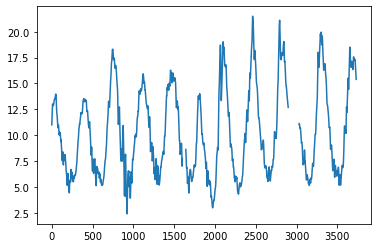

In [33]:
pltv = np.ma.array(trnd.abs_vals.temperature.values,mask=np.isnan(trnd.abs_vals.temperature.values))
pltv[np.isnan(pltv)]
plt.plot(pltv)

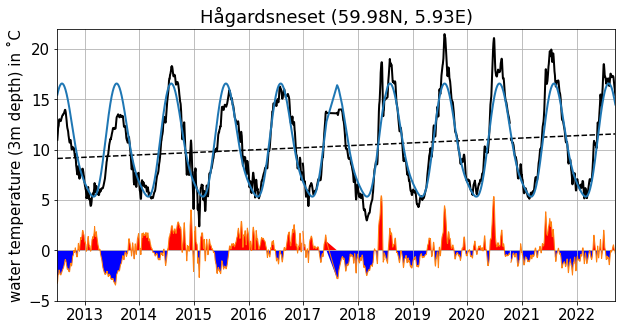

In [34]:
f,ax = plt.subplots(figsize=(10,5))

ax.set_xlabel('')
ax.set_ylabel('water temperature (3m depth) in ˚C',fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set_xlim(trnd.abs_vals.temperature.time[0],trnd.abs_vals.temperature.time[-1])
ax.set_ylim(-5,22)
ax.set_title('{0:s} ({1:2.2f}N, {2:2.2f}E)'.format(temp_3m_langoey.loc_name.values,temp_3m_langoey.lat.values,temp_3m_langoey.lon.values),fontsize=18)

ax.grid()

ax.plot(trnd.abs_vals.time,trnd.abs_vals.temperature,color='k',lw=2)
f.savefig(fpath + 'Haagardsneset_raw.png',bbox_inches='tight',dpi=300)

ax.plot(trnd.trend_line.time,trnd.trend_line.temperature,color='k',ls='dashed')
f.savefig(fpath + 'Haagardsneset_tr.png',bbox_inches='tight',dpi=300)

ax.plot(SC.sc_exp_doy.sortby('time').time,SC.sc_exp_doy.sortby('time').temperature,color='C0',lw=2)
f.savefig(fpath + 'Haagardsneset_sc.png',bbox_inches='tight',dpi=300)

# SC.absolute_vals.temperature.plot(ax=ax,color='C0')
anoms = SC.anomalies.sortby('time')
ax.plot(anoms.time,anoms.temperature,color='C1',lw=1)
y = np.ma.array(anoms.temperature.values,mask=np.isnan(anoms.temperature.values))
y[np.isnan(y)] = 0.00001
y_pos = anoms.temperature.values.copy()
y_pos[y_pos < 0] = 0
y_pos[np.isnan(y_pos)] = 0
y_neg = anoms.temperature.values.copy()
y_neg[y_neg > 0] = 0
y_neg[np.isnan(y_neg)] = 0
ax.fill_between(anoms.time, y_pos, facecolor='red')
ax.fill_between(anoms.time, y_neg, facecolor='blue')

f.savefig(fpath + 'Haagardsneset_an.png',bbox_inches='tight',dpi=300)

In [35]:
anom_pers = persistence(lags=5)
anom_pers.fit(SC.anomalies.temperature)

In [86]:
# itime = np.datetime64('{:}-{:0>2}-{:}'.format(st3m_langoey.ca8dhakpllnee2k58qfg_avg.index[-2].year,st3m_langoey.ca8dhakpllnee2k58qfg_avg.index[-2].month,st3m_langoey.ca8dhakpllnee2k58qfg_avg.index[-2].day))
# init_date = xr.DataArray(
#     itime,
#     dims = ('time',),
#     coords = dict(
#         time = [itime]
#     )
# )

In [87]:
# # initial condition:
# tr_init = trnd.predict(init_date,time_coord = 'time')
# sc_init = SC.predict(get_doy_coord(init_date),time_name='time')
# init_anom = st3m_langoey.ca8dhakpllnee2k58qfg_avg[-2] - tr_init + sc_init - trnd.mean

# init_anom = init_anom.assign_coords(month_day=get_doy_coord(init_date).values)

In [36]:
SC.anomalies.temperature.isel(time=-1)

<xarray.DataArray 'temperature' ()>
array(-0.32219472)
Coordinates:
    depth      int64 3
    time       datetime64[ns] 2022-09-16
    location   int64 22095
    loc_name   object 'Hågardsneset'
    lon        float64 5.93
    lat        float64 59.98
    month_day  int64 259

In [37]:
# prediction of the anomaly:
anom_pred = anom_pers.predict(SC.anomalies.temperature.isel(time=-1)) # needs an anomaly

trnd_prdctn = trnd.predict(anom_pred.time)

# prediction of seasonal cycle:
sc_pred = SC.predict(anom_pred.time_doy,time_name='lags')

abs_pred = anom_pred + sc_pred + trnd_prdctn - trnd.mean

In [58]:
anom_pred.time_doy

<xarray.DataArray 'time_doy' (lags: 6)>
array([259, 266, 273, 280, 287, 294])
Coordinates:
    depth     int64 3
    location  int64 22095
    loc_name  object 'Hågardsneset'
    lon       float64 5.93
    lat       float64 59.98
  * lags      (lags) int64 0 1 2 3 4 5
    time      (lags) datetime64[ns] 2022-09-16 2022-09-23 ... 2022-10-21
    time_doy  (lags) int64 259 266 273 280 287 294

In [44]:
t0 = SC.anomalies.temperature.isel(time=-1).time.values
print(t0)

2022-09-16T00:00:00.000000000


In [54]:
get_doy_coord(t0_xr)

<xarray.DataArray 'month_day' (time: 6)>
array([259, 266, 273, 280, 287, 294])
Coordinates:
  * time     (time) datetime64[ns] 2022-09-16 2022-09-23 ... 2022-10-21

In [59]:
nlag = 6
t0_xr = xr.DataArray(
    pd.date_range(start=t0,freq='7D',periods=nlag),
    dims = {'lags':nlag},
    coords = {
        'lags':('lags',np.arange(6)),
        'time':('lags',pd.date_range(start=t0,freq='7D',periods=nlag))
    }
)
trnd.predict(t0_xr)
SC.predict(get_doy_coord(t0_xr).rename({'time':'lags'}),time_name='lags')


<xarray.Dataset>
Dimensions:      (lags: 6)
Coordinates:
  * lags         (lags) datetime64[ns] 2022-09-16 2022-09-23 ... 2022-10-21
    depth        int64 3
    location     int64 22095
    loc_name     object 'Hågardsneset'
    lon          float64 5.93
    lat          float64 59.98
Data variables:
    temperature  (lags) float64 14.5 13.9 13.25 12.58 11.91 11.25

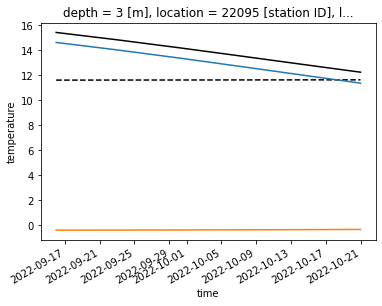

In [89]:
abs_pred.temperature.plot(x='time',color = 'k')
trnd_prdctn.temperature.plot(x='time',color = 'k', ls= 'dashed')
sc_pred.temperature.plot(x='time',color = 'C0')
anom_pred.plot(x='time',color = 'C1')

In [90]:
# write values to list
obs_fc_list = list(np.concatenate((temp_3m_langoey.temperature.values, abs_pred.temperature.values), axis=None))
# write corresponding dates to list:
obs_fc_time_list = list(np.concatenate((temp_3m_langoey.temperature.time.values, abs_pred.temperature.time.values), axis=None))

In [91]:
# Define signal metadata:
signal_name = '{0:s} Norkyst800 & forecast'.format(temp_3m_langoey.temperature.standard_name)
signal_desc = 'Norkyst800 and Persistence forecast of 7-day averages up to 4 weeks ahead {0:}-{1:0>2d}-{2:0>2d}'.format(datetime.today().year,datetime.today().month,datetime.today().day)
signal_unit = response_filtered.result.items[item_id[0]].engUnit
signal_labels = {'data-source':['Norkyst800 + Persistence Model'],'site':[str(temp_3m_langoey.loc_name.values)],'depth':['{0:d} {1:s}'.format(temp_3m_langoey.depth.values,temp_3m_langoey.depth.units)]}

# Create a signal and write metadata to it
signal = SignalInfo(name = signal_name, description = signal_desc, engUnit = signal_unit, labels = signal_labels, sourceType = 'prediction')
client.save_signals(input_ids=['nk800_persistence_fc'], signals=[signal], create_only=False)
# Write data into a signal
data_obs_fc = DataFrame(series={'nk800_persistence_fc': obs_fc_list}, times = obs_fc_time_list)
client.insert(data_obs_fc)

Response(jsonrpc='2.0', id='1', result=InsertResponse(signalsByInput={'nk800_persistence_fc': InsertSummary(id='ccl00fnqfsjcmon89ae0', created=False)}), error=None)